# Домашнее задание №10. Машинный перевод. Модель seq2seq и механизм внимания

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

## Задание
Разобраться с моделькой перевода как она устроена
запустить для перевода с русского на английский (при желании можно взять другие пары языков) два варианта с вниманием и без внимания
оценить качество насколько корректно переводит 

## План решения

[0. Загрузка и просмотр данных](#section_0)

[1. Подготовка данных](#section_1)

[2. Построение датасета](#section_2)

[3. Построение модели машинного перевода](#section_3)

[4. Построение модели машинного перевода с вниманием](#section_4)

## 0. Загрузка и просмотр данных <a id='section_0'></a>

We'll use a language dataset provided by http://www.manythings.org/anki/

In [2]:
#Скачиваем датасет
!wget http://www.manythings.org/anki/rus-eng.zip

--2022-06-25 03:23:21--  http://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.21.92.44, 172.67.186.54, 2606:4700:3030::6815:5c2c, ...
Connecting to www.manythings.org (www.manythings.org)|104.21.92.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14819554 (14M) [application/zip]
Saving to: ‘rus-eng.zip’

rus-eng.zip         100%[===================>]  14.13M  --.-KB/s    in 0.08s   

2022-06-25 03:23:21 (180 MB/s) - ‘rus-eng.zip’ saved [14819554/14819554]



In [3]:
#Создаем папку и извлекаем туда файлы из архива
!mkdir rus-eng
!unzip rus-eng.zip -d rus-eng/

Archive:  rus-eng.zip
  inflating: rus-eng/rus.txt         
  inflating: rus-eng/_about.txt      


In [4]:
!ls /content/rus-eng/ -lah

total 71M
drwxr-xr-x 2 root root 4.0K Jun 25 03:23 .
drwxr-xr-x 1 root root 4.0K Jun 25 03:23 ..
-rw-r--r-- 1 root root 1.5K May  2 01:29 _about.txt
-rw-r--r-- 1 root root  71M May  2 01:29 rus.txt


In [5]:
# Загружаем файл
path_to_file = "/content/rus-eng/rus.txt"

In [6]:
#просмотр файла
f = open(path_to_file)
for line in f:
    print(line)
    break

Go.	Марш!	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1159202 (shanghainese)



## 1. Подготовка данных <a id='section_1'></a>

**Препроцессим слова**

In [7]:
#функция препроцессинга
def preprocess_sentence(w):
  #переводим предложение к нижнему регистру и удалем начальные и конечные пробелы
    w = w.lower().strip()

  # отделяем пробелом слово и следующую за ним пунктуацию
  # пример: "he is a boy." => "he is a boy ."
    w = re.sub(r"([?.!,])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

  # все, кроме букв и знаков пунктуации, заменяем пробелом
    w = re.sub(r"[^a-zA-Zа-яА-Я?.!,']+", " ", w)
  
  #удаляем лишние пробелы в начале и конце
    w = w.strip()

  # создаем начало и конец последовательности
  # теперь модель знает, где начинать и заканчивать предсказания
    w = '<start> ' + w + ' <end>'
    return w

In [8]:
#пример работы препроцессинга
preprocess_sentence("I can't go.")

"<start> i can't go . <end>"

**Создаем датасет**

In [9]:
# 1. Убираем акценты
# 2. Очищаем предложения
# 3. Возвращаем пары слов: [ENG, RUS]
def create_dataset(path, num_examples):
  #считываем строки файла
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  #каждую строку разделяем на пробелы, берем первые 2 слова, препроцессим их и возвращаем пару
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]

    return zip(*word_pairs)

In [10]:
#пример работы
en, ru = create_dataset(path_to_file, None)
print(en[0])
print(ru[0])

<start> go . <end>
<start> марш ! <end>


In [11]:
# количество данных в датасете
len(en), len(ru)

(444587, 444587)

**Загрузчик датасета**

In [12]:
def tokenize(lang):
      #токенизируем текст, отфильтвовываем пробелы
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
      #обновляем внутренний словарь на основе lang
    lang_tokenizer.fit_on_texts(lang)
      #преобразуем каждый элемент из lang в последовательность чисел
    tensor = lang_tokenizer.texts_to_sequences(lang)
      #преобразуем тензор в матрицу (кол-во тензоров * max-длина), 
      #при этом короткие последовательности заполняем нулями сзади, а длинные -- обрезаем сзади
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

## 2. Создание датасета <a id='section_2'></a>

In [13]:
def load_dataset(path, num_examples=None):
      # создаем очищенные анг (выходные), русские (входные) пары
    targ_lang, inp_lang = create_dataset(path, num_examples)
    #применяем токенизацию к каждому элементы из пары
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [14]:
num_examples = 100000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

input_tensor, target_tensor

(array([[    1,  5674,    24, ...,     0,     0,     0],
        [    1,   198,     3, ...,     0,     0,     0],
        [    1,   298,     3, ...,     0,     0,     0],
        ...,
        [    1,    19, 20543, ...,     0,     0,     0],
        [    1,    19,     9, ...,     0,     0,     0],
        [    1,    19,    60, ...,     0,     0,     0]], dtype=int32),
 array([[  1,  27,   3, ...,   0,   0,   0],
        [  1,  27,   3, ...,   0,   0,   0],
        [  1,  27,   3, ...,   0,   0,   0],
        ...,
        [  1,  28, 377, ...,   0,   0,   0],
        [  1,  28, 113, ...,   2,   0,   0],
        [  1,  28, 113, ...,   0,   0,   0]], dtype=int32))

In [15]:
# Вычисляем максимальную длину тензоров
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
max_length_targ, max_length_inp

(11, 15)

In [16]:
# Создаем тренировочные и валидационные датасеты
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# размеры датасетов
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

80000 80000 20000 20000


In [17]:
input_tensor_train, target_tensor_train

(array([[    1,     4, 12845, ...,     0,     0,     0],
        [    1,     4,   122, ...,     0,     0,     0],
        [    1,     8,  3059, ...,     0,     0,     0],
        ...,
        [    1,     4,  1280, ...,     0,     0,     0],
        [    1,    52,  6672, ...,     0,     0,     0],
        [    1,    30,    35, ...,     0,     0,     0]], dtype=int32),
 array([[   1,   13, 1304, ...,    0,    0,    0],
        [   1,    4,  202, ...,    0,    0,    0],
        [   1,   30,    9, ...,    0,    0,    0],
        ...,
        [   1,    4,  170, ...,    0,    0,    0],
        [   1,  178, 1813, ...,    0,    0,    0],
        [   1,   49,   15, ...,    0,    0,    0]], dtype=int32))

In [18]:
#функция получения из токена текста (выводим токен и его индекс)
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [19]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
4 ----> я
12845 ----> заботливая
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
13 ----> i'm
1304 ----> attentive
3 ----> .
2 ----> <end>


In [20]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
#количество эпох
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 300
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1
#из каждого элемента (input_tensor_train, target_tensor_train) создает тензор
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
#разбиваем датасет на батчи (списки по 64), удаляя последний неполный батч
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [21]:
example_input_batch, example_target_batch = next(iter(dataset))
print(example_input_batch.shape, example_target_batch.shape)
example_input_batch[0], example_target_batch[0]

(64, 15) (64, 11)


(<tf.Tensor: shape=(15,), dtype=int32, numpy=
 array([  1,  41,   4,   8, 148,  31,  70,   5,   2,   0,   0,   0,   0,
          0,   0], dtype=int32)>,
 <tf.Tensor: shape=(11,), dtype=int32, numpy=array([ 1, 26,  4, 15, 10, 51,  7,  6,  2,  0,  0], dtype=int32)>)

## 3. Построение модели машинного перевода <a id='section_3'></a>

**Encoder**

In [22]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=False,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return state

    def initialize_hidden_state(self):
    #создаем тензор из нулей размера (батч, кол-во ячеек)
        return tf.zeros((self.batch_sz, self.enc_units))

In [23]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# инициализитеруем начальное скрытое состояние (из нулей)
sample_hidden = encoder.initialize_hidden_state()
# применяем энкодер к входному батчу и скрытому состоянию
sample_hidden = encoder(example_input_batch, sample_hidden)
# print ('Форма выхода энкодера: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder Hidden state shape: (batch size, units) (64, 1024)


In [24]:
sample_hidden

<tf.Tensor: shape=(64, 1024), dtype=float32, numpy=
array([[-0.00110117, -0.00859911, -0.00462004, ..., -0.01819532,
        -0.0028524 , -0.00916994],
       [-0.00164753, -0.00866196, -0.00467848, ..., -0.02000468,
        -0.00233006, -0.00901685],
       [-0.00159242, -0.00859456, -0.00472685, ..., -0.01961127,
        -0.0024938 , -0.00907685],
       ...,
       [-0.00152131, -0.00879055, -0.00464797, ..., -0.01911295,
        -0.00250089, -0.00912412],
       [-0.00163826, -0.00868252, -0.00461944, ..., -0.01982511,
        -0.00240002, -0.00901911],
       [-0.00155627, -0.00866286, -0.0046927 , ..., -0.01969648,
        -0.00239793, -0.008963  ]], dtype=float32)>

**Decoder**

In [25]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

    def call(self, x, hidden):
        # x shape после прохождения через эмбеддинг == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # отправляем в GRU входные данные и скрытое состояние (от энкодера)
        #выход GRU (batch_size, timesteps, units)
        #размер возвращаемого внутреннего состояния (batch_size, units)
        output, state = self.gru(x, initial_state=hidden)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # x shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state

In [26]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
#применяем декодер к случайному батчу из равномерного распределения (батч,1) и выходу энкодера
decoder_sample_x, decoder_sample_h = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden)
decoder_sample_x.shape, decoder_sample_h.shape

(TensorShape([64, 7334]), TensorShape([64, 1024]))

In [27]:
decoder_sample_x

<tf.Tensor: shape=(64, 7334), dtype=float32, numpy=
array([[-0.00655841, -0.00250829,  0.00747077, ...,  0.0116556 ,
         0.00273022, -0.00024858],
       [-0.00636877, -0.0024961 ,  0.00727615, ...,  0.01152185,
         0.00267674, -0.00059519],
       [-0.00639946, -0.00250283,  0.00731826, ...,  0.01154647,
         0.00269514, -0.00053566],
       ...,
       [-0.00643168, -0.00250159,  0.00732332, ...,  0.01155275,
         0.00269297, -0.00050411],
       [-0.00641484, -0.00246874,  0.0073247 , ...,  0.01152155,
         0.00264437, -0.00053896],
       [-0.00643821, -0.00247792,  0.00730544, ...,  0.01151908,
         0.00265886, -0.00056407]], dtype=float32)>

**Компиляция модели**

In [28]:
#оптимизатор
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

#функция потерь
def loss_function(real, pred):
      #делаем инверсию значений сравнения каждого из real с нулем (возвращается true или false)
    mask = tf.math.logical_not(tf.math.equal(real, 0))
      #применяем функцию ошибок к реальным данным и предсказанным
    loss_ = loss_object(real, pred)
      #приводим тензор mask к новому типу loss_.dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
      #умножаем loss_ на mask
    loss_ *= mask
      # возвращаем среднее значениe всех элементов
    return tf.reduce_mean(loss_)

**Сheckpoint**

In [29]:
checkpoint_dir = './training_nmt_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

**Обучение модели**

In [30]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
  # перечисляем операции для автоматического дифференцирования
    with tf.GradientTape() as tape:
        #получаем выход encoder
        enc_hidden = encoder(inp, enc_hidden)
        #помещаем его в скрытое состояние decoder
        dec_hidden = enc_hidden
        #формируем вход декодера:
                 # берем список длины батч из индексов тега <start> (1)
                 # приписываем списку размерность 1 сзади (батч, 1)
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - выводим target в качестве следующего входа
        for t in range(1, targ.shape[1]):
          # помещаем enc_output в decoder
            predictions, dec_hidden = decoder(dec_input, dec_hidden)
          # считаем функцию потерь 
            loss += loss_function(targ[:, t], predictions)
          # используем teacher forcing (приписываем списку размерность 1 сзади)
          #посылаем dec_input на вход декордера 
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))
    #переменные
    variables = encoder.trainable_variables + decoder.trainable_variables
    #вычисляем градиенты loss по variables
    gradients = tape.gradient(loss, variables)
    #оптимизатор применяет подсчитанные градиенты
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [31]:
EPOCHS = 50

for epoch in range(EPOCHS):
    start = time.time()

  #инициализируем входное скрытое состояние (из нулей) размера (батч, кол-во рекуррентных ячеек)
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        #делаем шаг обучения. находим оштбку за этоху
        batch_loss = train_step(inp, targ, enc_hidden)
        #считаем ошибку
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                       batch,
                                                       batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.7036
Epoch 1 Batch 100 Loss 1.9311
Epoch 1 Batch 200 Loss 1.8197
Epoch 1 Batch 300 Loss 1.5989
Epoch 1 Batch 400 Loss 1.4893
Epoch 1 Batch 500 Loss 1.5000
Epoch 1 Batch 600 Loss 1.3500
Epoch 1 Batch 700 Loss 1.3540
Epoch 1 Batch 800 Loss 1.3698
Epoch 1 Batch 900 Loss 1.3535
Epoch 1 Batch 1000 Loss 1.2902
Epoch 1 Batch 1100 Loss 1.1329
Epoch 1 Batch 1200 Loss 1.1521
Epoch 1 Loss 1.5189
Time taken for 1 epoch 68.27928709983826 sec

Epoch 2 Batch 0 Loss 1.0590
Epoch 2 Batch 100 Loss 1.0206
Epoch 2 Batch 200 Loss 0.9244
Epoch 2 Batch 300 Loss 0.9553
Epoch 2 Batch 400 Loss 0.9520
Epoch 2 Batch 500 Loss 0.8827
Epoch 2 Batch 600 Loss 0.8300
Epoch 2 Batch 700 Loss 0.8617
Epoch 2 Batch 800 Loss 0.8326
Epoch 2 Batch 900 Loss 0.7842
Epoch 2 Batch 1000 Loss 0.7590
Epoch 2 Batch 1100 Loss 0.6293
Epoch 2 Batch 1200 Loss 0.7097
Epoch 2 Loss 0.8739
Time taken for 1 epoch 59.274983644485474 sec

Epoch 3 Batch 0 Loss 0.5961
Epoch 3 Batch 100 Loss 0.5807
Epoch 3 Batch 200 Loss 0.52

**Перевод**
* Функция оценки аналогична циклу обучения, за исключением того, что здесь мы не используем *teacher forcing*. Входным сигналом для декодера на каждом временном шаге являются его предыдущие предсказания вместе со скрытым состоянием и выходным сигналом энсодера.
* Предсказания модели прекращаются, когда модель предскажет *end token*.
* Сохраняем *веса внимания для каждого временного шага*.

Примечание: Выходной сигнал энкодера вычисляется только один раз для одного входа.

In [32]:
def evaluate(sentence):
  #препоцессим предложение
    sentence = preprocess_sentence(sentence)
      #разбиваем предложение по пробелам и составляем список индексов каждого слова
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
      #добиваем inputs нулями справа до максимальной длины входного текста
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                             maxlen=max_length_inp,
                                                             padding='post')
      #преобразуем inputs в тензор
    inputs = tf.convert_to_tensor(inputs)

    result = ''
      # инициализируем входной хидден из нулей размера (1, units)
    hidden = [tf.zeros((1, units))]
      #подаем inputs и hidden в encoder
    enc_hidden = encoder(inputs, hidden)

      #инициализируем входной хидден декодера -- выходной хидден энкодера
    dec_hidden = enc_hidden
      #вход декодера -- список [индекс start] размера(1,1)
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
            #получаем выход декодера
        predictions, dec_hidden = decoder(dec_input, dec_hidden)

        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '

   #заканчиваем на токене end
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence

    # предсказанный predicted ID подаем обратно в декодер (размер (1,1))
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence

In [33]:
#функция перевода
def translate(sentence):
    result, sentence = evaluate(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

In [34]:
# загружаем последний checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [35]:
translate('Хорошая погода')

Input: <start> хорошая погода <end>
Predicted translation: it's nice of town . <end> 


In [36]:
translate('Я иду в школу')

Input: <start> я иду в школу <end>
Predicted translation: i go to school . <end> 


In [38]:
translate('Я иду на урок  в школу')

Input: <start> я иду на урок в школу <end>
Predicted translation: i came to school at school . <end> 


In [39]:
translate('Я сам решаю трудную задачу в школе')

Input: <start> я сам решаю трудную задачу в школе <end>
Predicted translation: i will keep it school . <end> 


In [40]:
translate(u'Я не люблю, когда идет снег.')

Input: <start> я не люблю , когда идет снег . <end>
Predicted translation: i don't like snow . <end> 


In [41]:
translate(u'Сегодня я пойду гулять, а потом пойду в магазин')

Input: <start> сегодня я пойду гулять , а потом пойду в магазин <end>
Predicted translation: i will go now open . <end> 


In [43]:
translate('Мама приготовила вкусный обед для нашей большой семьи')

Input: <start> мама приготовила вкусный обед для нашей большой семьи <end>
Predicted translation: my mother will find us . <end> 


In [44]:
translate(u'Мне здесь нравится, но я очень скучаю по дому. Там остались мама и папа.')

Input: <start> мне здесь нравится , но я очень скучаю по дому . там остались мама и папа . <end>
Predicted translation: both of you just gift . <end> 


**Вывод:** на длинных предложениях перевод плохой. Вероятно это связано с отсутствием учета контекста.

## 4. Построение модели машинного перевода с вниманием <a id='section_4'></a>

**Encoder**

In [45]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [46]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# инициализируем начальное скрытое состояние из нулей
sample_hidden = encoder.initialize_hidden_state()
#получаем выход энкодера и последнее скрытое состояние
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 15, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


**Attention**

In [47]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # values shape == (batch_size, max_len, hidden size)

        # query_with_time_axis shape == (batch_size, 1, hidden size)
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        
        #применяем к векторам скрытого состояния и выходов энкодера полносвязный слой (выход (batch_size, 1, units) и (batch_size, max_length, units))
        #складываем полученные векторы, применяем к сумму тангенс выход (batch_size, max_length, units)
        #проводим результат через dense слой выход (batch_size, max_length, 1)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        # получаем вероятностное распределение
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        # умножаем веса внимания умножаем на векторы значенй выход (batch_size, max_len, hidden size)
        context_vector = attention_weights * values
        #находим вдоль столбцов (batch_size, hidden_size)
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [48]:
#создаем слой внимания
attention_layer = BahdanauAttention(10)
#передаем выход энкодера и его скрытое состояние
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 15, 1)


In [49]:
#вектор контекста
attention_result

<tf.Tensor: shape=(64, 1024), dtype=float32, numpy=
array([[-7.5024855e-03,  5.2073020e-03, -4.6310672e-03, ...,
         2.7755972e-03,  2.0767376e-03,  5.4401075e-03],
       [-6.7798020e-03,  1.1909818e-02, -8.3595710e-03, ...,
         4.4256505e-03, -1.5806464e-03,  1.2681620e-02],
       [-6.7438362e-03,  1.0096085e-02, -1.1062435e-02, ...,
         1.3879724e-03,  1.8201201e-04,  9.5589124e-03],
       ...,
       [-1.0864353e-03,  8.5423011e-03, -1.2706023e-02, ...,
        -3.8043677e-04,  9.3839742e-04,  9.2417859e-03],
       [-8.4144026e-03,  1.1886423e-02, -7.6369937e-03, ...,
         8.5177016e-05,  2.5819056e-03,  1.3227359e-02],
       [-6.0605668e-03,  8.6819381e-03, -9.7763138e-03, ...,
         1.6886444e-03, -9.9868793e-04,  1.0302559e-02]], dtype=float32)>

In [50]:
#веса внимания
attention_weights

<tf.Tensor: shape=(64, 15, 1), dtype=float32, numpy=
array([[[0.06650431],
        [0.06640393],
        [0.06675882],
        [0.06689087],
        [0.06673609],
        [0.06603233],
        [0.06538902],
        [0.06603517],
        [0.06577487],
        [0.06671555],
        [0.06714514],
        [0.06733041],
        [0.06740525],
        [0.06743374],
        [0.06744447]],

       [[0.06643756],
        [0.06597944],
        [0.0642005 ],
        [0.06537272],
        [0.06547338],
        [0.06658485],
        [0.06707428],
        [0.06727152],
        [0.06734288],
        [0.06736588],
        [0.06737309],
        [0.06737647],
        [0.06737944],
        [0.06738251],
        [0.06738542]],

       [[0.06615514],
        [0.06586711],
        [0.06560668],
        [0.06614016],
        [0.0661419 ],
        [0.06595773],
        [0.06681417],
        [0.0671291 ],
        [0.06721569],
        [0.06721628],
        [0.06719187],
        [0.06716586],
        [0.06714536

**Decoder**

In [51]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        # используем слой внимания
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        # получаем выходы слоя внимания (из скрытого состояния и выхода энкодера)
        # context_vector shape == (batch_size, hidden_size)
        # attention_weights shape == (batch_size, max_len, 1)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        #соединяем выход эмбеддинга с вектором контекста и подаем навход RNN
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # (batch_size, 1, hidden_size) --> output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [52]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
#применяем декодер к случайному батчу из равномерного распределения (батч,1) и выходам энкодера
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 7334)


In [53]:
sample_decoder_output

<tf.Tensor: shape=(64, 7334), dtype=float32, numpy=
array([[ 5.2247872e-04,  7.8537408e-04, -2.2845012e-03, ...,
         3.4707505e-03, -1.3952043e-04,  5.7674194e-04],
       [ 8.0357969e-04,  4.6254962e-04, -2.1414156e-03, ...,
         4.4369339e-03,  8.8747701e-04,  1.1363184e-03],
       [ 1.0366219e-03,  4.8535469e-05, -2.0459627e-03, ...,
         3.6208541e-03,  9.9681644e-04,  1.3798700e-03],
       ...,
       [-1.2609805e-04,  9.2520501e-04, -2.2295725e-03, ...,
         3.8111883e-03,  1.3589175e-04,  6.4282713e-04],
       [ 1.0900099e-03,  7.6923246e-04, -1.5007656e-03, ...,
         4.0601669e-03,  1.4646900e-03,  1.0454012e-03],
       [ 6.1029755e-04,  3.8153073e-04, -2.1402340e-03, ...,
         4.3877182e-03,  3.8281770e-04,  1.5736750e-03]], dtype=float32)>

**Сheckpoint**

In [54]:
checkpoint_dir = './training_attention_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

**Обучение модели**

In [55]:
@tf.function
def train_step_att(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        #получаем выходы encoder
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        #помещаем выходное скрытое состояние энкодера в скрытое состояние decoder
        dec_hidden = enc_hidden
        #формируем вход декодера:
             # берем список длины батч из индексов тега <start>
             # приписываем списку размерность 1 сзади
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - выводим target в качестве следующего входа
        for t in range(1, targ.shape[1]):
          # помещаем enc_output, dec_input, dec_hidden в decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            # считаем функцию потерь 
            loss += loss_function(targ[:, t], predictions)
            # используем teacher forcing (приписываем списку размерность 1 сзади)
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))
    #переменные
    variables = encoder.trainable_variables + decoder.trainable_variables
    #вычисляем градиенты loss по variables
    gradients = tape.gradient(loss, variables)
    #оптимизатор применяет подсчитанные градиенты
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [56]:
EPOCHS = 50

for epoch in range(EPOCHS):
    start = time.time()

    #инициализируем входное скрытое состояние (из нулей) размера (батч, кол-во рекуррентных ячеек)
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        #делаем шаг обучения
        batch_loss = train_step_att(inp, targ, enc_hidden)
        #считаем ошибку
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                       batch,
                                                       batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.7034
Epoch 1 Batch 100 Loss 2.0827
Epoch 1 Batch 200 Loss 1.7865
Epoch 1 Batch 300 Loss 1.7777
Epoch 1 Batch 400 Loss 1.5474
Epoch 1 Batch 500 Loss 1.4858
Epoch 1 Batch 600 Loss 1.4680
Epoch 1 Batch 700 Loss 1.2858
Epoch 1 Batch 800 Loss 1.2438
Epoch 1 Batch 900 Loss 1.2074
Epoch 1 Batch 1000 Loss 1.1863
Epoch 1 Batch 1100 Loss 1.1809
Epoch 1 Batch 1200 Loss 1.0962
Epoch 1 Loss 1.4716
Time taken for 1 epoch 114.7339096069336 sec

Epoch 2 Batch 0 Loss 0.9865
Epoch 2 Batch 100 Loss 0.7423
Epoch 2 Batch 200 Loss 0.9106
Epoch 2 Batch 300 Loss 0.8240
Epoch 2 Batch 400 Loss 0.8617
Epoch 2 Batch 500 Loss 0.9022
Epoch 2 Batch 600 Loss 0.8089
Epoch 2 Batch 700 Loss 0.6332
Epoch 2 Batch 800 Loss 0.6697
Epoch 2 Batch 900 Loss 0.6320
Epoch 2 Batch 1000 Loss 0.6159
Epoch 2 Batch 1100 Loss 0.6177
Epoch 2 Batch 1200 Loss 0.5725
Epoch 2 Loss 0.7528
Time taken for 1 epoch 102.85561919212341 sec

Epoch 3 Batch 0 Loss 0.5184
Epoch 3 Batch 100 Loss 0.4714
Epoch 3 Batch 200 Loss 0.47

**Перевод**

In [57]:
def evaluate_att(sentence):
    #строим матрицу внимания из нулей размера (макс длина таргета, макс длина входа)  
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    #препоцессим предложение
    sentence = preprocess_sentence(sentence)
    #разбиваем предложение по пробелам и составляем список индексов каждого слова
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    #добиваем inputs нулями справа до максимальной длины входного текста
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    #преобразуем inputs в тензор
    inputs = tf.convert_to_tensor(inputs)

    result = ''
    # инициализируем входной хидден из нулей размера (1, units)
    hidden = [tf.zeros((1, units))]
    #подаем inputs и hidden в encoder
    enc_out, enc_hidden = encoder(inputs, hidden)

    #инициализируем входной хидден декодера -- выходной хидден энкодера
    dec_hidden = enc_hidden
    #вход декодера -- список [индекс start] размера(1,1)  
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        #получаем выход декодера
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

        # сохраняем веса внимания, чтобы позже визуализировать
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '

        #заканчиваем на токене end
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

    # предсказанный predicted ID подаем обратно в декодер (размер (1,1))
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [58]:
# визуализация весов внимания
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [59]:
def translate_att(sentence):
    result, sentence, attention_plot = evaluate_att(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [60]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> хорошая погода <end>
Predicted translation: that's a good joke . <end> 


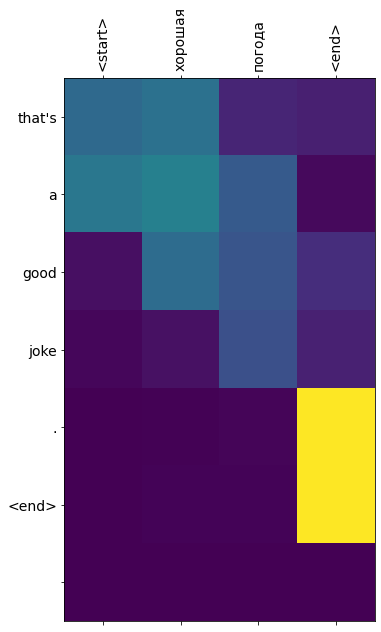

In [61]:
translate_att('Хорошая погода')

Input: <start> я иду в школу <end>
Predicted translation: am i walk ? <end> 


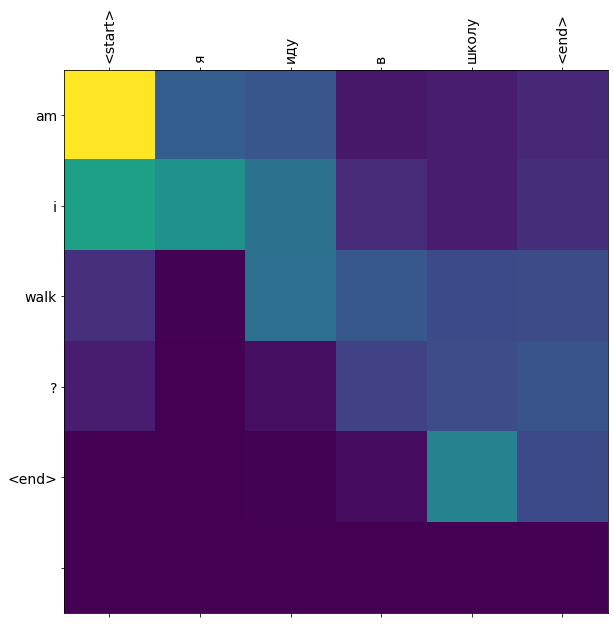

In [62]:
translate_att('Я иду в школу')

Input: <start> я иду на урок в школу <end>
Predicted translation: was leaving the truck ? <end> 


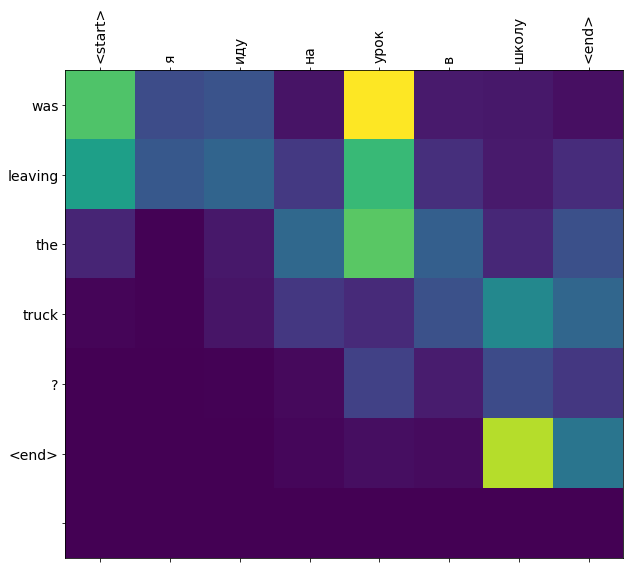

In [64]:
translate_att('Я иду на урок в школу')

Input: <start> я сам решаю трудную задачу в школе <end>
Predicted translation: am i myself or school ? <end> 


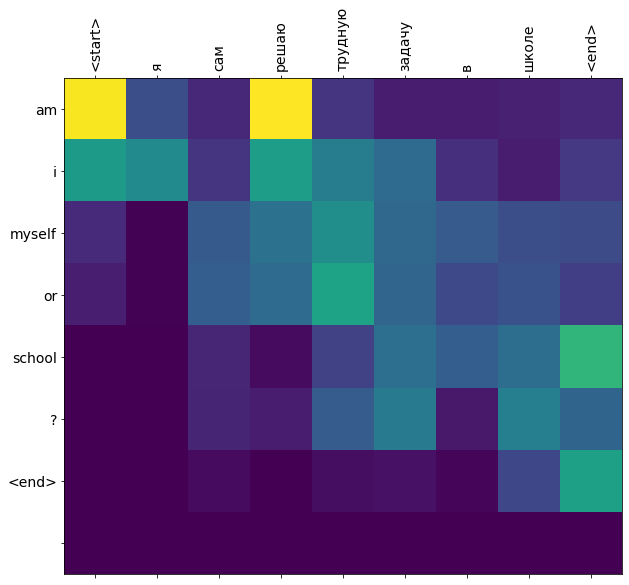

In [65]:
translate_att('Я сам решаю трудную задачу в школе')

Input: <start> я не люблю , когда идет снег . <end>
Predicted translation: i don't like rain . <end> 


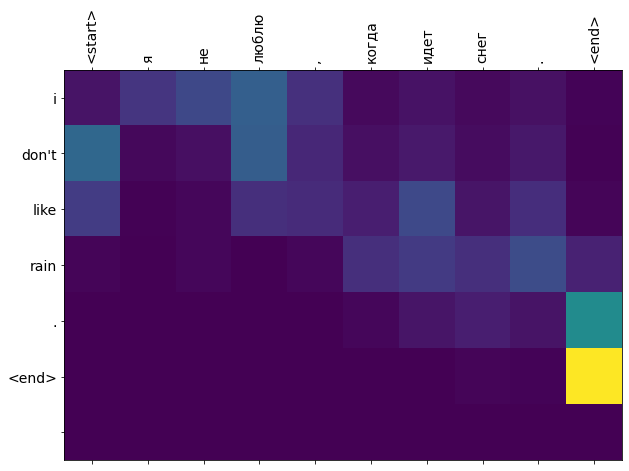

In [66]:
translate_att(u'Я не люблю, когда идет снег.')

Input: <start> сегодня я пойду гулять , а потом пойду в магазин <end>
Predicted translation: i'll go once a tv today . <end> 


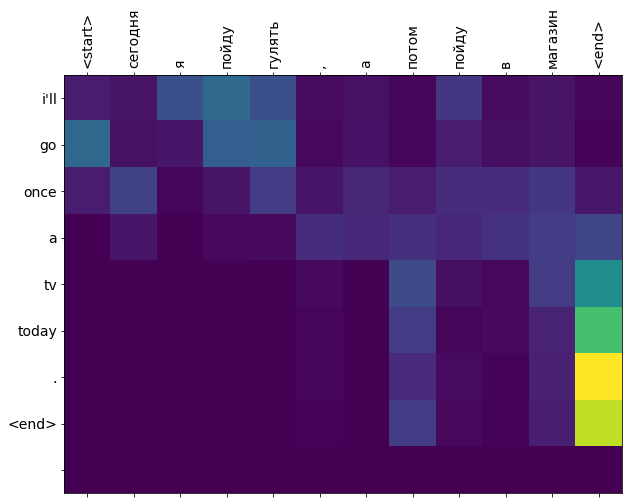

In [67]:
translate_att(u'Сегодня я пойду гулять, а потом пойду в магазин')

Input: <start> мама приготовила вкусный обед для нашей большой семьи <end>
Predicted translation: how is tom's family is big milk ! <end> 


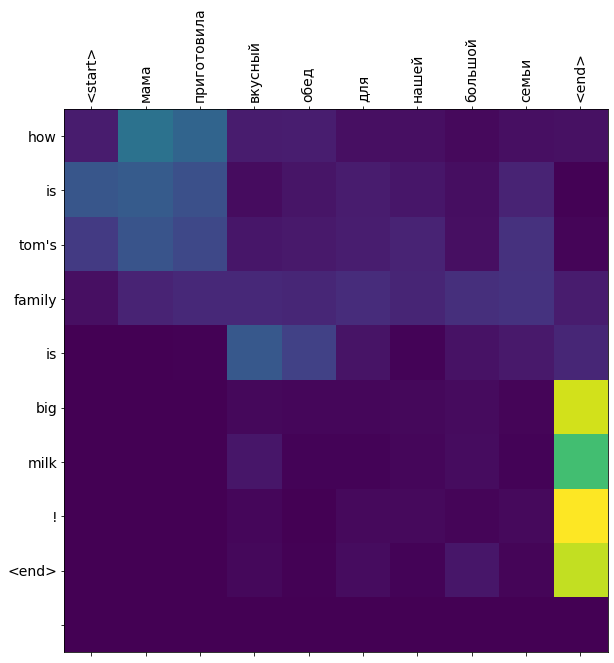

In [69]:
translate_att('Мама приготовила вкусный обед для нашей большой семьи')

Input: <start> мне здесь нравится , но я очень скучаю по дому . там остались мама и папа . <end>
Predicted translation: my mother my i was . <end> 


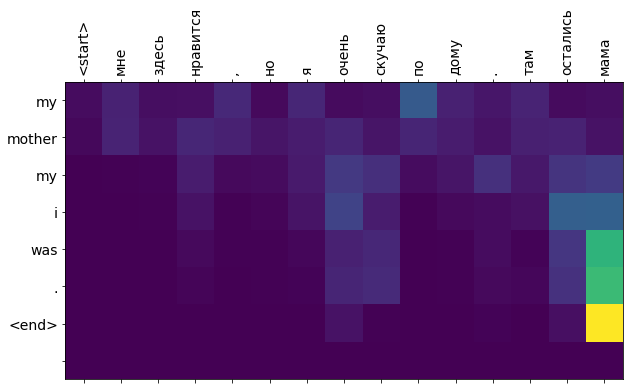

In [70]:
translate_att(u'Мне здесь нравится, но я очень скучаю по дому. Там остались мама и папа.')

**Вывод:** Перевод модели с вниманием также имеет неточности.